# Bayesian optimization

* Mainly used for optimization of "heavy" functions (computationally complex, expensive to evaluate)
* The objective function can be "black box"
* Uses approximation of the objective function
* Takes into account quality of the approximation

#### Optimization procedure:
1. Build approximation $\hat{f}(x)$ of function $f(x)$
2. Choose new point as an argmax of the criterion
$$
x_{new} = \arg\max\limits_x a(x)
$$
3. Evaluate $f(x)$ at new point
4. Update model $\hat{f}(x)$ and go to step 2.


### Expected Improvement

$$
EI(x) = \mathbb{E}_{p(\hat{f})} \left [\max(0, y_{min} - \hat{f}) \right ]
$$
where $\hat{y}, \sigma$ - mean and variance of GP model at point $x$,
$\Phi(\cdot)$ - cdf of standard normal distribution,
$\phi(\cdot)$ - pdf of standard normal distribution.

Usually logarithm of EI is used.

<img src="EI_vs_logEI.png">

### Optimization of criterion

Any optimization algorithm could be used.

In this seminar we will use multi-start with L-BFGS optimization algorithm

Multi-start procedure:
1. Generate initial set of points $x_1, \ldots, x_n$. Calculate criterion at each point to obtain $(a(x_1), \ldots, a(x_n))$.
2. Choose $k$ points with smallest values of criterion.
3. Using each point as an initial point run the optimization algorithm (L-BFGS) and obtain $k$ optimization results.
4. From all optimization results choose the best one.

### L-BFGS 

It's a quasi-Newton method of optimization and it is based on second order Taylor expansion
$$
f(x_k + p) \approx f(x_k) + \nabla f^T(x_k) p + \frac12 p^T \mathbf{H}p
$$
$$
p = -\mathbf{H}^{-1}\nabla f^T(x_k) \approx -\mathbf{B}_k^{-1} \nabla f^T(x_k),
$$
where $\mathbf{B}_k$ is an approximation of hessian $\mathbf{H}$.

Approximation $\mathbf{B}_k$ is updated at every step by the following rule:
$$
\mathbf{B}_{k + 1} = \mathbf{B}_k - \frac{\mathbf{B}_k s_k s_k^T \mathbf{B}_k}{s_k^T \mathbf{B}_k s_k} + \frac{y_k y_k^T}{y_k^T s_k},
$$
where $s_k = x_{k + 1} - x_k$, $y_k = \nabla f(x_{k + 1}) - \nabla f(x_k)$.

In [1]:
%matplotlib inline

from __future__ import print_function

import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import minimize


import GPy

import bayes_opt


def f(x):
    return (6 * x - 2)**2 * np.sin(12 * x - 4)  

def get_1d_data():
    np.random.seed(239)
    x_train = np.array([0.0, 0.58, 0.38, 0.95]).reshape(-1, 1)
    y_train = f(x_train)
    return x_train, y_train

In [2]:
x_train, y_train = get_1d_data()
kernel = GPy.kern.RBF(1, variance=0.5, lengthscale=0.2)
model = GPy.models.GPRegression(x_train, y_train, kernel)

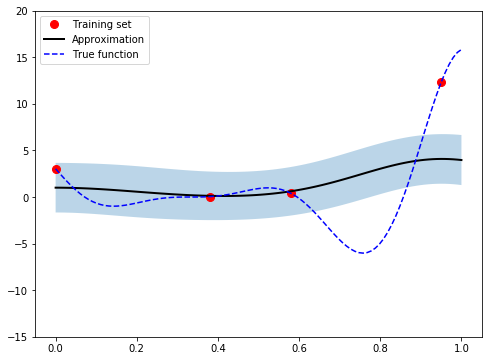

In [3]:
x_grid = np.linspace(0, 1, 100).reshape(-1, 1)
y_grid = f(x_grid)
prediction, std = model.predict(x_grid)
prediction = prediction.ravel()
std = std.ravel()
pyplot.figure(figsize=(8, 6))
pyplot.plot(x_train, y_train, 'or', markersize=8, label='Training set')
pyplot.plot(x_grid, prediction, '-k', linewidth=2, label='Approximation')
pyplot.fill_between(x_grid.ravel(), prediction - 2 * std, prediction + 2 * std, alpha=0.3)
pyplot.plot(x_grid, y_grid, '--b', label='True function')
pyplot.ylim([-15, 20])
pyplot.legend(loc='best')

### Task

Derive expression for EI: express it in terms of $\Phi(\cdot)$ and $\phi(\cdot)$ - cdf and pdf of $\mathcal{N}(0, 1)$.

### Solution

$$
EI = \int_{-\infty}^{y_{min}} (y_{min} - \hat{y}) \frac{1}{\sqrt{2 \pi} \sigma} \exp \left (-\frac{(\hat{y} - \mu)^2}{2 \sigma^2} \right ) d\hat{y} = \left |t = \frac{\hat{y} - \mu}{\sigma}, 
\quad z = \frac{y_{min} - \mu}{\sigma}\right | = \\
\int_{-\infty}^z (y - \mu - \sigma t)\phi(t) dt = (y - \mu) \Phi(z) - \sigma \int_{-\infty}^z t \phi(t) dt
$$
$$
\int_{-\infty}^z t\phi(t)dt = \int_{-\infty}^z \frac{1}{\sqrt{2 \pi}}t e^{-t^2 / 2}dt = \int\limits_{+\infty}^{\dfrac{z^2}{2}}\dfrac{1}{\sqrt{2\pi}}e^{-x}dx = -\dfrac{1}{\sqrt{2\pi}}e^{\dfrac{z^2}{2}} = - \phi(z)
$$
$$
\Rightarrow EI = (y_{min} - \mu) \Phi\left ( \frac{y_{min} - \mu}{\sigma} \right ) + \sigma \phi \left ( \frac{y_{min} - \mu}{\sigma}\right )
$$


### Task
Implement multi-start optimization procedure

In [6]:
def get_new_point(model, lb, ub, data=None, multistart=10, criterion='ei', k=1, random_state=None):
    """
    Parameters:
        model - GP model of the objective function
        lb, ub - array-like, lower and upper bounds of x
        data - tuple(x_train, y_train)
        multistart - number of multistart runs
        criterion - aqcuisition function, by default EI
        k - parameter of the LowerConfidenceBound function
        random_state - np.random.RandomState
    Returns
        tuple - argmin of the objective function and min value of the objective 
    """
    if random_state is None:
        random_state = np.random.RandomState()

    lb = np.array(lb).reshape(1, -1)
    ub = np.array(ub).reshape(1, -1)
    
    # 1. Generate inital X points (number of points == multistart) in [lb, ub]
    
    ######## Your code here ########
    x_random = random_state.uniform(size=(multistart, np.array(lb).ravel().shape[0]))
    x_random *= ub - lb
    x_random += lb

    ######## ########
    def objective(x):
        if x.ndim == 1:
            x = x.reshape(1, -1)
        mean_values, variance = model.predict(x)
        std_values = np.sqrt(variance)
        if criterion == 'ei':
            return -bayes_opt.log_expected_improvement(mean_values, std_values, data[1].min())
        elif criterion == 'lcb':
            return bayes_opt.lcb(mean_values, std_values, params)
        else:
            raise NotImplementedError('Criterion is not implemented!')

    criterion_value = objective(x_random)
    
    # 2. From each points from x_random run L-BFGS optimization algorithm, 
    #    choose the best result and return it
    #    Use function minimize: minimize(objective, x_init, method='L-BFGS-B',
    #                                    bounds=np.vstack((lb, ub)).T)
    #    it returns object with fields 'fun' - optimum function value, 'x' - argmin.

    best_result = None
    best_value = np.inf

    ######## Your code here ########
    for x_init in x_random:
        optimization_result = minimize(objective, x_init, method='L-BFGS-B', bounds=np.vstack((lb, ub)).T)

        if optimization_result.fun < best_value:
            best_result = optimization_result
            best_value = best_result.fun[0]
    
    return best_result.x, best_result.fun

In [7]:
# Check your code 
lb = [0]
ub = [1]
kernel = GPy.kern.RBF(1, variance=0.5, lengthscale=0.1)
model = GPy.models.GPRegression(x_train, y_train, kernel)
x_new, f_new = get_new_point(model, lb, ub, data=(x_train, y_train), random_state=np.random.RandomState(42))

assert(np.isclose(x_new, 0.29985639))
assert(np.isclose(f_new, 0.86480674))
print('Correct!')

Correct!


In [8]:
def optimization_step(x_train, y_train, kernel, objective, lb=None, ub=None, criterion='ei', k=1, plot=False):
    model = GPy.models.GPRegression(x_train, y_train, kernel)
    model.optimize_restarts(num_restarts=10, verbose=False)

    x_new, criterion_value = get_new_point(model, data=(x_train, y_train), lb=lb, ub=ub, criterion=criterion, k=k)
    if plot:
        bayes_opt.plot1d(x_train, y_train, model, objective, x_new, criterion_value)
        pyplot.show()

    x_new = x_new.reshape(1, -1)
    x_train = np.vstack([x_train, x_new])
    y_train = np.vstack([y_train, np.asarray(objective(x_new)).reshape(1, -1)])
    return x_train, y_train, model

## 1D example

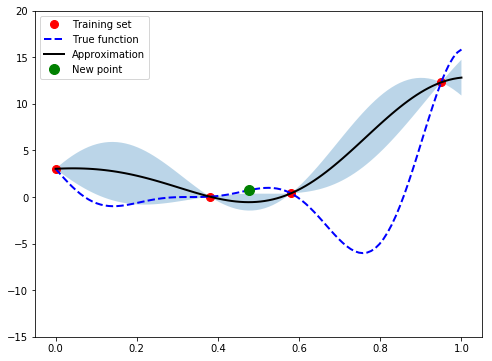

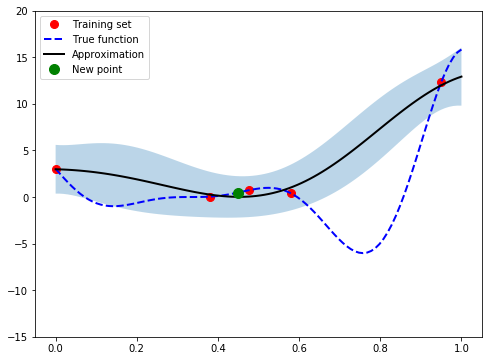

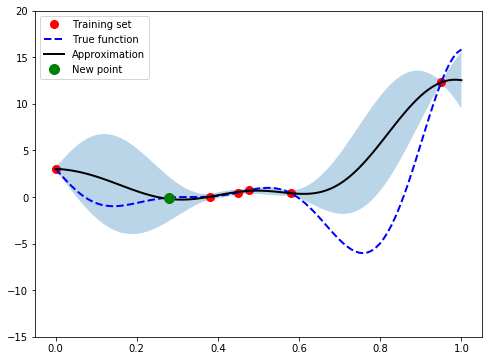

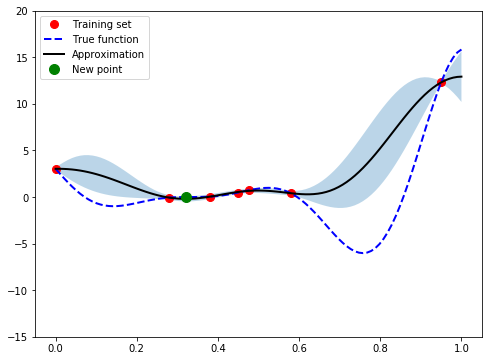

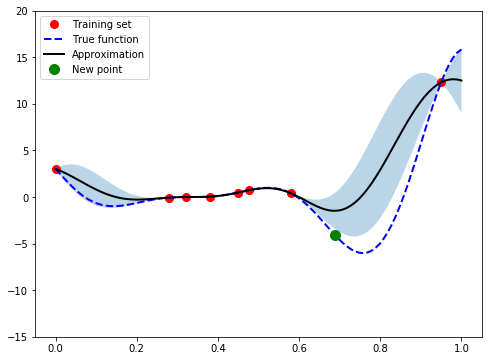

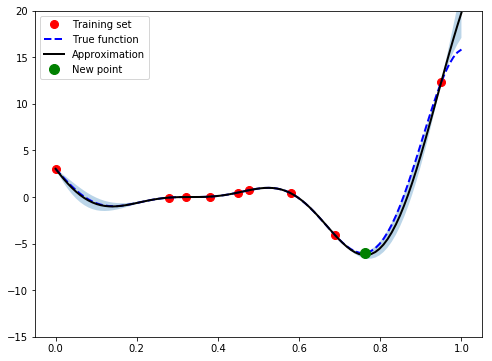

In [9]:
x_train, y_train = get_1d_data()
kernel = GPy.kern.RBF(1, variance=0.5, lengthscale=0.2)
model = GPy.models.GPRegression(x_train, y_train, kernel)
for i in range(6):
    x_train, y_train, model = bayes_opt.optimization_step(x_train, y_train, kernel, f, lb=[0], ub=[1], criterion='ei', plot=True)

## 2D demo

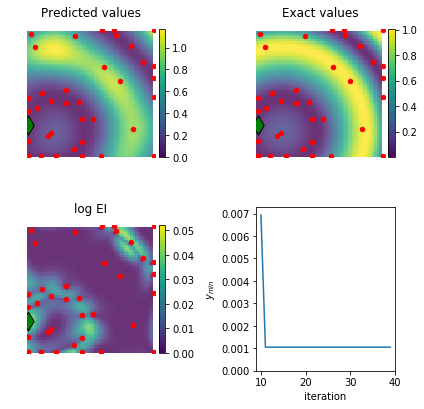

In [10]:
budget = 30
n_init = 10

kernel = GPy.kern.RBF(2, variance=1, lengthscale=0.5, ARD=False)

save_path = '2d_demo.mp4'
bayes_opt.demo_2d(n_init, budget, kernel, save_path=save_path)

In [11]:
import io
import base64
from IPython.display import HTML

video = io.open(save_path, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### Hyperparmeters tuning

* Almost all machine learning have hyperparameters
* Quality of the model depends on the hyperparameters
* Quality estimation for one set of hyperparameters can take long time
* => Bayesian optimization can be used for hyperparameters tuning.

#### Bayesian optimization for hyperparameter tuning

Objective function to optimize
* Takes hyperparameters as input
* Builds a model (maybe several times in case of cross-validation)
* Calculates and returns model quality

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost

from IPython import display

##### House pricing dataset

In this task you need to predict House Sale Price. There are 25 numerical input features like lot area, overall condition rating, house quality, number of kitchens and so on (there were a lot of categorical variables which we removed in this example for simplicity).

We are going to tune XGBoost parameters using Bayesian Optimization to obtain more accurate model.

In [13]:
data = np.loadtxt('house_pricing.csv')

X = data[:, :-1]
y = data[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

We implement `model_error_cv()` function that will be our objective function.  
We are going to use RBF kernel in our Bayesian Optimization, the result of optimization will be continuous variables,
so we need to preprocess parameters - cast integer parameters to int.

In [14]:
def wrap_parameters(parameters, scaler=None):
    if scaler:
        parameters = scaler.transform(parameters)
    return parameters


def unwrap_parameters(parameters, scaler=None):
    if scaler:
        parameters = scaler.inverse_transform(parameters)
    p = [int(parameters[0]), parameters[1], int(parameters[2]),
         max(0, min(parameters[3], 1))]
    return p


def model_error_cv(parameters, X, y, scaler=None):
    errors = []
    for p in parameters:
        p = unwrap_parameters(p, scaler)
        model = xgboost.XGBRegressor(max_depth=p[0],
                                     learning_rate=p[1],
                                     n_estimators=p[2],
                                     subsample=p[3],
                                     )

        score = cross_val_score(model, X, y, cv=3).mean()
        errors.append(score)
    return np.array(errors).reshape(-1, 1)

We scale the parameters using StandardScaler() from sklearn - it is nice to have all the parameters with unit variance and mean zero
when using RBF kernel as it is easier to tune lengthscale parameters, because these parameters depend on the range of input variables.

In [17]:
# xgboost params: max_depth, learning_rate, n_estimators, subsample
lower_bound = np.array([1, 0.001, 100, 0.2])
upper_bound = np.array([6, 0.1, 1000, 1])

np.random.seed(42)
n_init_points = 10
initial_parameters = np.random.rand(n_init_points, len(lower_bound)) * (upper_bound - lower_bound) + lower_bound
initial_errors = -model_error_cv(initial_parameters, X, y)

scaler = StandardScaler()
scaler.fit(initial_parameters)
lower_bound = scaler.transform(lower_bound)
upper_bound = scaler.transform(upper_bound)
initial_parameters = wrap_parameters(initial_parameters, scaler)

 /home/yermek/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning:Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
 /home/yermek/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning:Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.


It is also nice idea to explicitly constrain lengthscale parameter - it shouldn't be much larger than distance between points in the training set, it shouldn't be much smaller than the distance between points in the training set.

In [18]:
kernel = GPy.kern.RBF(len(lower_bound), lengthscale=(upper_bound - lower_bound).min() / n_init_points, ARD=False)
gp_model = GPy.models.GPRegression(initial_parameters, initial_errors, kernel=kernel)
gp_model.rbf.lengthscale.constrain_bounded(0.001, 10)
gp_model.optimize()
print(gp_model)
print(gp_model.rbf.lengthscale)


Name : GP regression
Objective : -8.913282244811748
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |             value  |  constraints  |  priors
  rbf.variance             |    0.248637222824  |      +ve      |        
  rbf.lengthscale          |              10.0  |  0.001,10.0   |        
  Gaussian_noise.variance  |  0.00169449357162  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                    10.00000000  |  0.001,10.0   |        


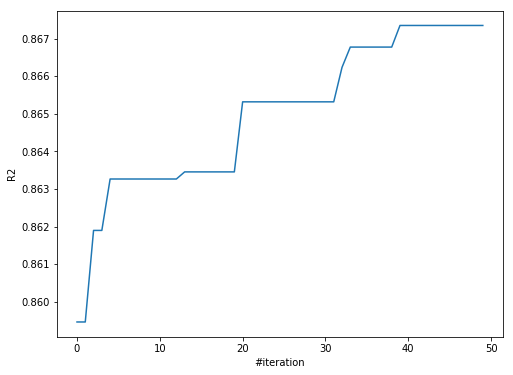

New parameters: [2, 0.018374739442706057, 525, 0.83203142446339728], new error:	0.8559303482830879
best parameters: [4, 0.017092188015627906, 694, 0.57105672429954202], best error:	0.8673576160155024
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     1.30063029  |  0.001,10.0   |        


In [19]:
budget = 40

hyperparameters = initial_parameters
errors = initial_errors
error_history = [-initial_errors[:i].min() for i in range(1, n_init_points + 1)]
objective = lambda x: -model_error_cv(x, X, y, scaler)
for i in range(budget):
    hyperparameters, errors, gp_model = bayes_opt.optimization_step(hyperparameters, errors, kernel, objective,
                                                                    lb=lower_bound, ub=upper_bound)
    error_history.append(-errors.min())
    # Visualize
    display.clear_output(wait=True)
    pyplot.figure(figsize=(8, 6))
        
    pyplot.xlabel("#iteration")
    pyplot.ylabel("R2")
    pyplot.plot(error_history)
    pyplot.show()
    
    print("New parameters: {}, new error:\t{}\nbest parameters: {}, best error:\t{}".format(
        unwrap_parameters(hyperparameters[-1], scaler), -errors[-1, 0],
        unwrap_parameters(hyperparameters[errors.argmin()], scaler), -errors.min()))
    print(gp_model.rbf.lengthscale)